In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = pd.read_excel('EPOC dataset.xlsx')

columns = ['metal','support','wt.%','ionic species','particle size(nm)','metal loading (mg)','CO2:H2 ratio','temp(℃)','rCO(mol/s)',
          'voltage(V)','ρCO','ΛCO']
data = data[columns]

# change string in data['metal'] into int with metal's atomic mass
data['metal'] = data['metal'].replace(['Fe','Co','Ni','Cu','ZnO','Ru','Rh','Pd','Pt'],
                                      ['55.8','58.9','58.7','63.5','65.4','101.1','102.9','106.4','195.1']).astype(float)

# change string in data['wt.%'] into int, where 100: no support
data['wt.%'] = data['wt.%'].fillna(100).astype(float)


# change string in data['CO2:H2 ratio'] into int by calculating the ratios
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))

# delete the data['CO2:H ratio'] column, which has been converted into data['gas ratio']
data = data.drop('CO2:H2 ratio', axis=1)

# change the columns' names into abbreviations, where M:metal, S:support, WT.%:wt.%, IS:ionic species, PS:particle size,
# L:metal loading, T: temperature, RR:reaction rate, V:applied potential, ρ:enhancement ratio, Λ:Faradaic efficiency, GR:gas ratio
data.columns = ['M','S','WT','IS','PS','L','T','RR','V','ρ','Λ','GR']

# determine the ionic species charge
ionic_charge = {
    'O2-': -2,
    'H+': 1,
    'Li+': 1,
    'Na+': 1,
    'K+': 1,
    'none': 0
}
data['IS_charge'] = data['IS'].replace(ionic_charge).fillna(0).astype(float)

# define a function to determine which direction the IS migrates. Value of 1 means IS moves to catalyst, -1 means IS removes from catalyst
def ionic_dir(row):
    if row['IS_charge'] * row['V'] < 0:
        return 1
    else:
        return -1
# create a new column named 'MD' (migration direction)
data['MD'] = data.apply(ionic_dir, axis=1)

# define a function to make a classification for EPOC behavior based on the applied potential and ρ values
# 0: electrophobic, 1: electrophilic
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

# create a new column named 'BH' (EPOC behavior)
data['BH'] = data.apply(electro_class, axis=1)

data['IS'] = data['IS'].fillna('none')
data['S'] = data['S'].fillna('none')
data = pd.get_dummies(data, columns=['IS'], prefix='I')
data = pd.get_dummies(data, columns=['S'], prefix='S')

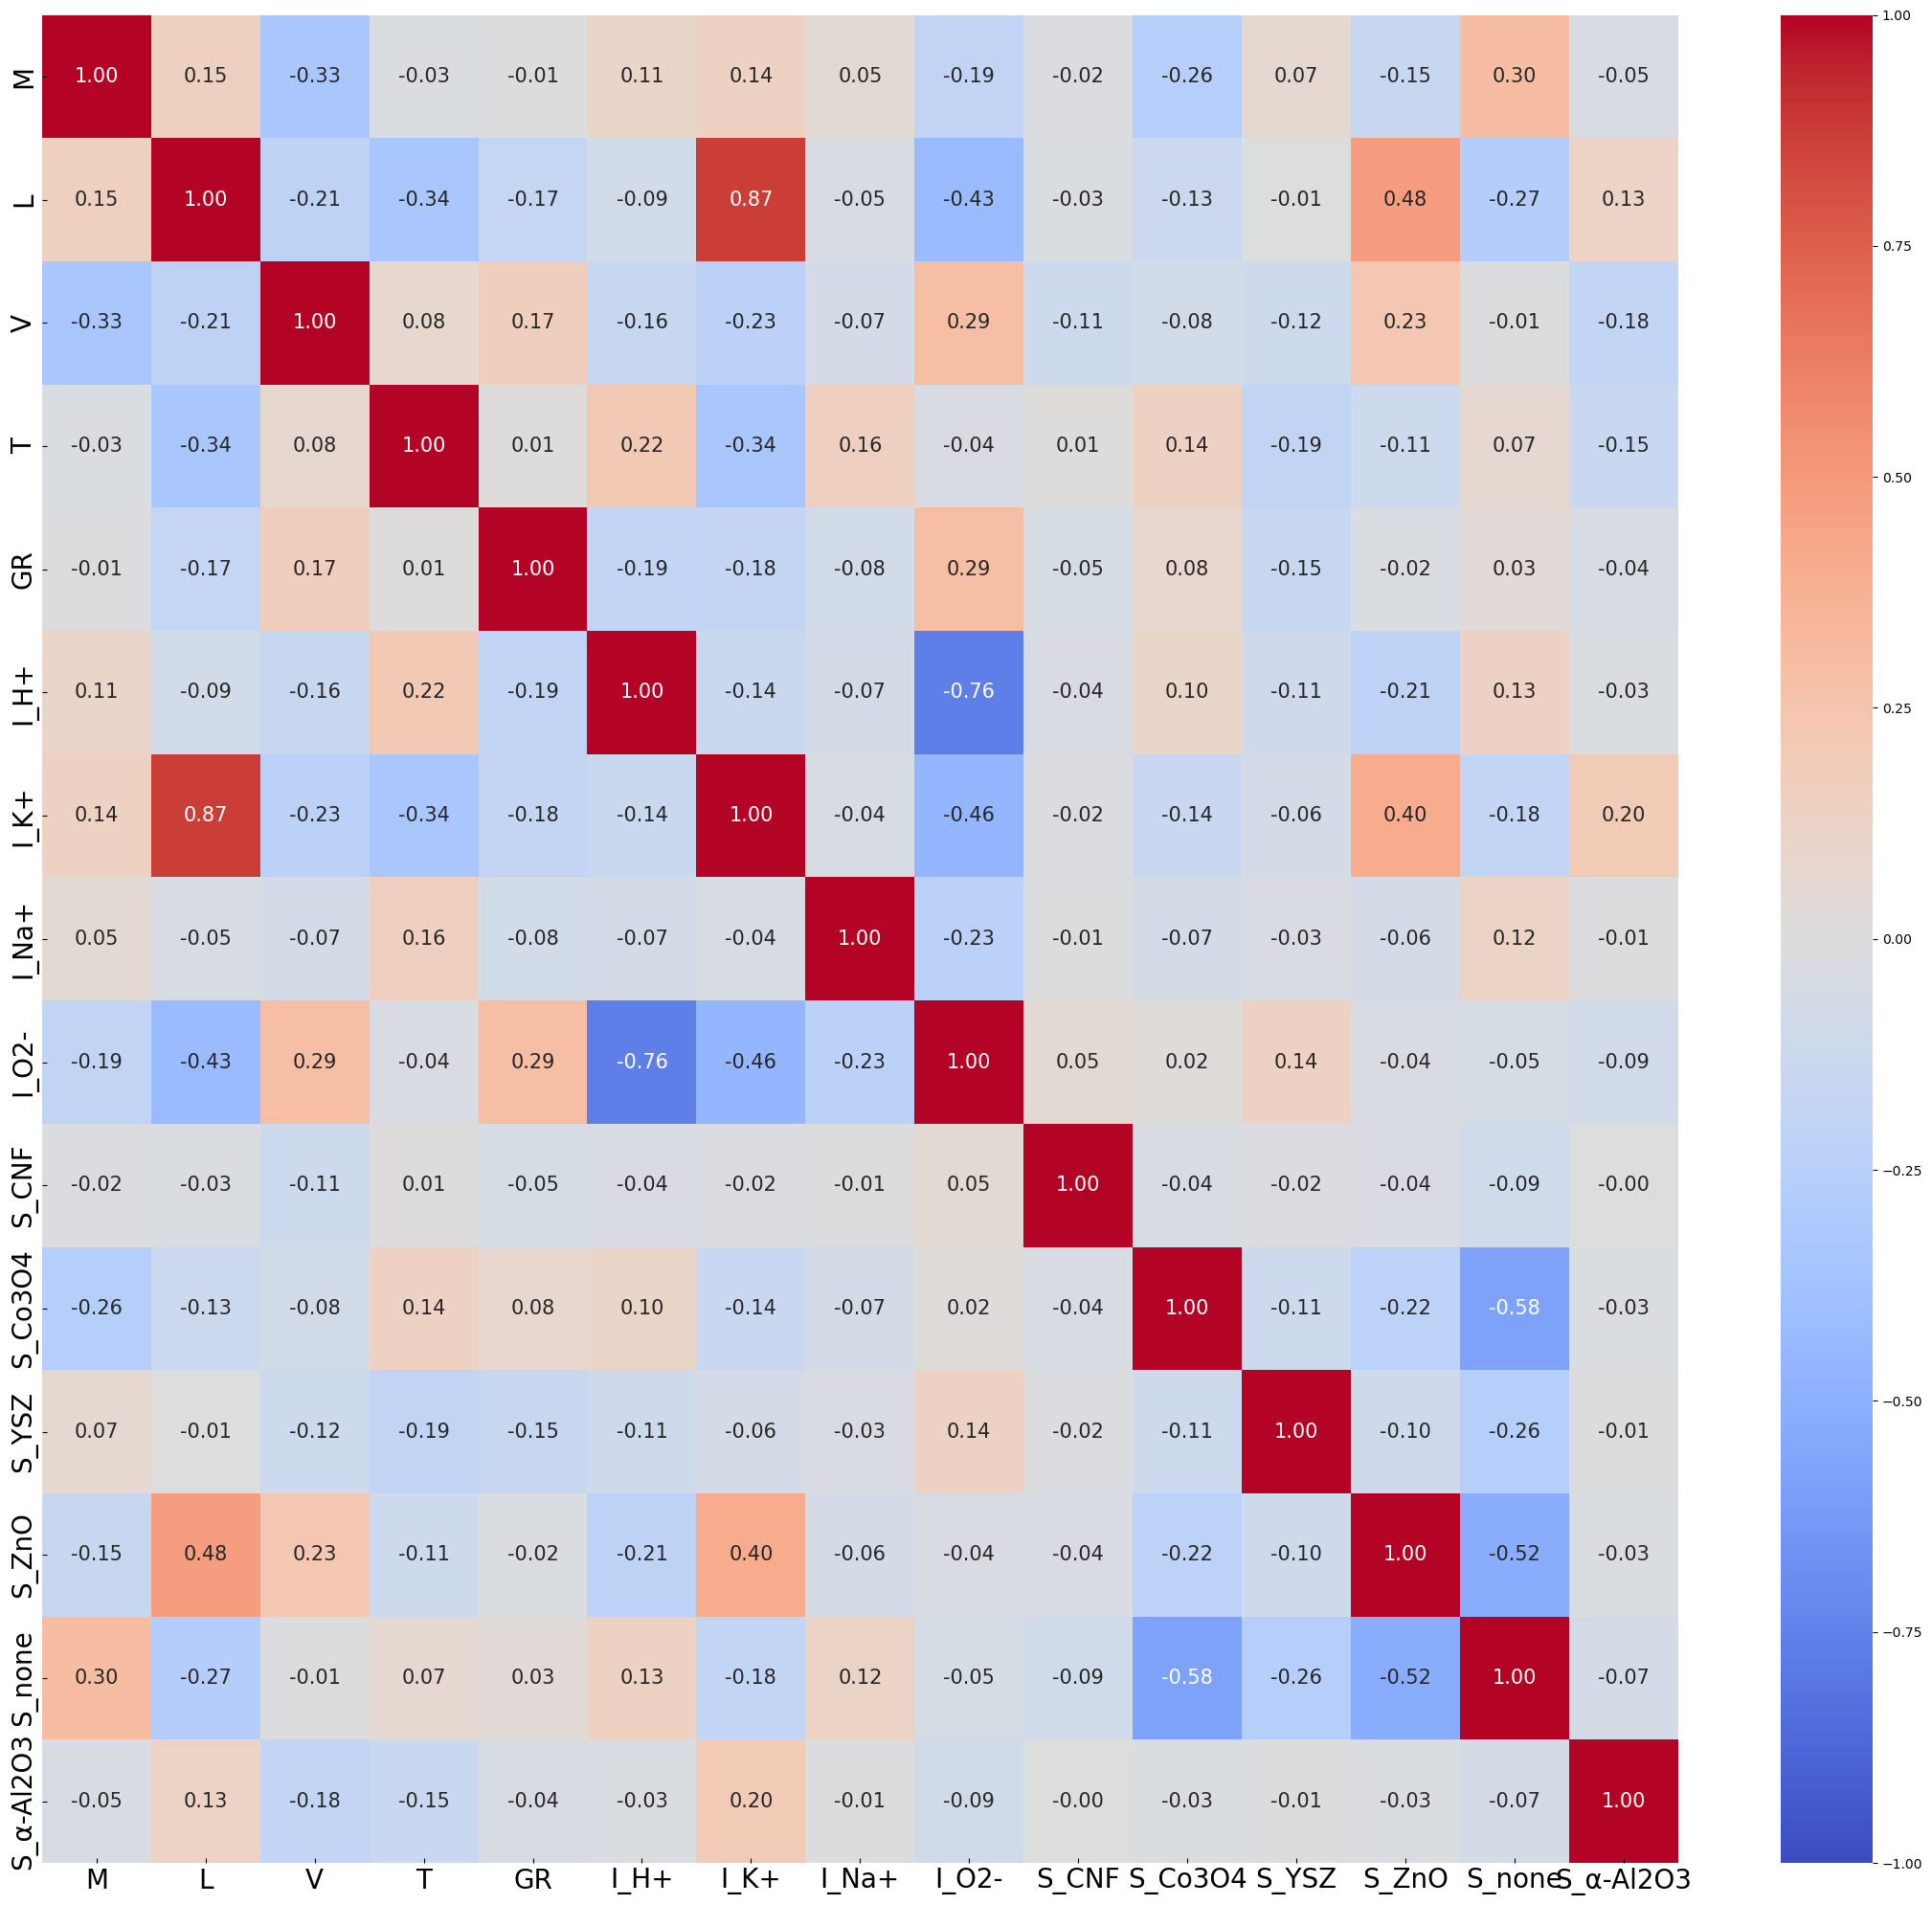

In [10]:
import seaborn as sns

# determine the columns that are used as features
features = ['M', 'L', 'V', 'T', 'GR'] + [col for col in data.columns if col.startswith('I_') or col.startswith('S_')]

X1 = data[features]
fig1 = plt.figure(figsize=(22,20))
corr_matrix1 = X1.corr()
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, annot_kws={"size": 15})
plt.tick_params(which='both', direction='in', labelsize=20)

plt.tight_layout()
plt.savefig('Correlation Matrix (all features).jpg', format='jpeg', dpi=600)
plt.show()

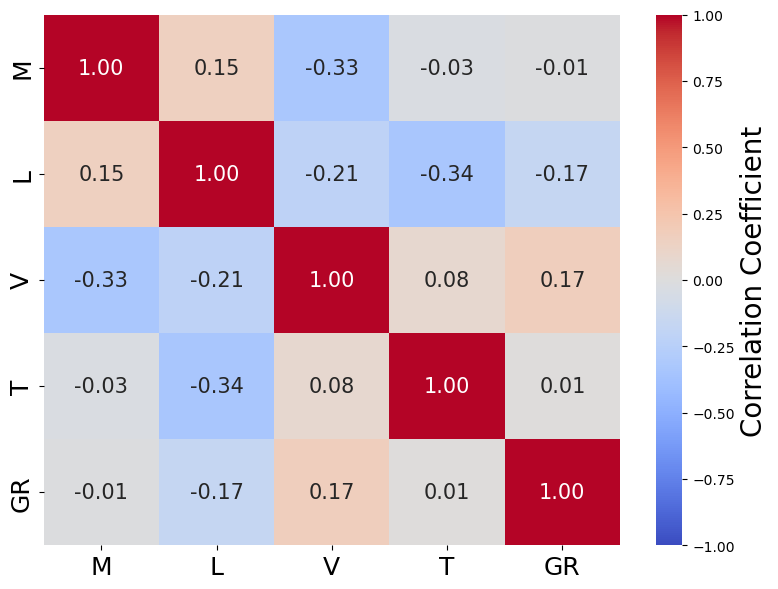

In [11]:
import seaborn as sns

# determine the columns that are used as features
sel_features = ['M', 'L', 'V', 'T', 'GR']

X2 = data[sel_features]
corr_matrix2 = X2.corr()
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = sns.heatmap(
    corr_matrix2, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    vmin=-1, vmax=1,
    annot_kws={"size": 15},
    cbar_kws={'label': 'Correlation Coefficient'},
    ax=ax
)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation Coefficient', fontsize=20)

ax.tick_params(axis='both', which='both', labelsize=18)

plt.tight_layout()
plt.savefig('Correlation Matrix (reduced features).jpg', format='jpeg', dpi=600)
plt.show()

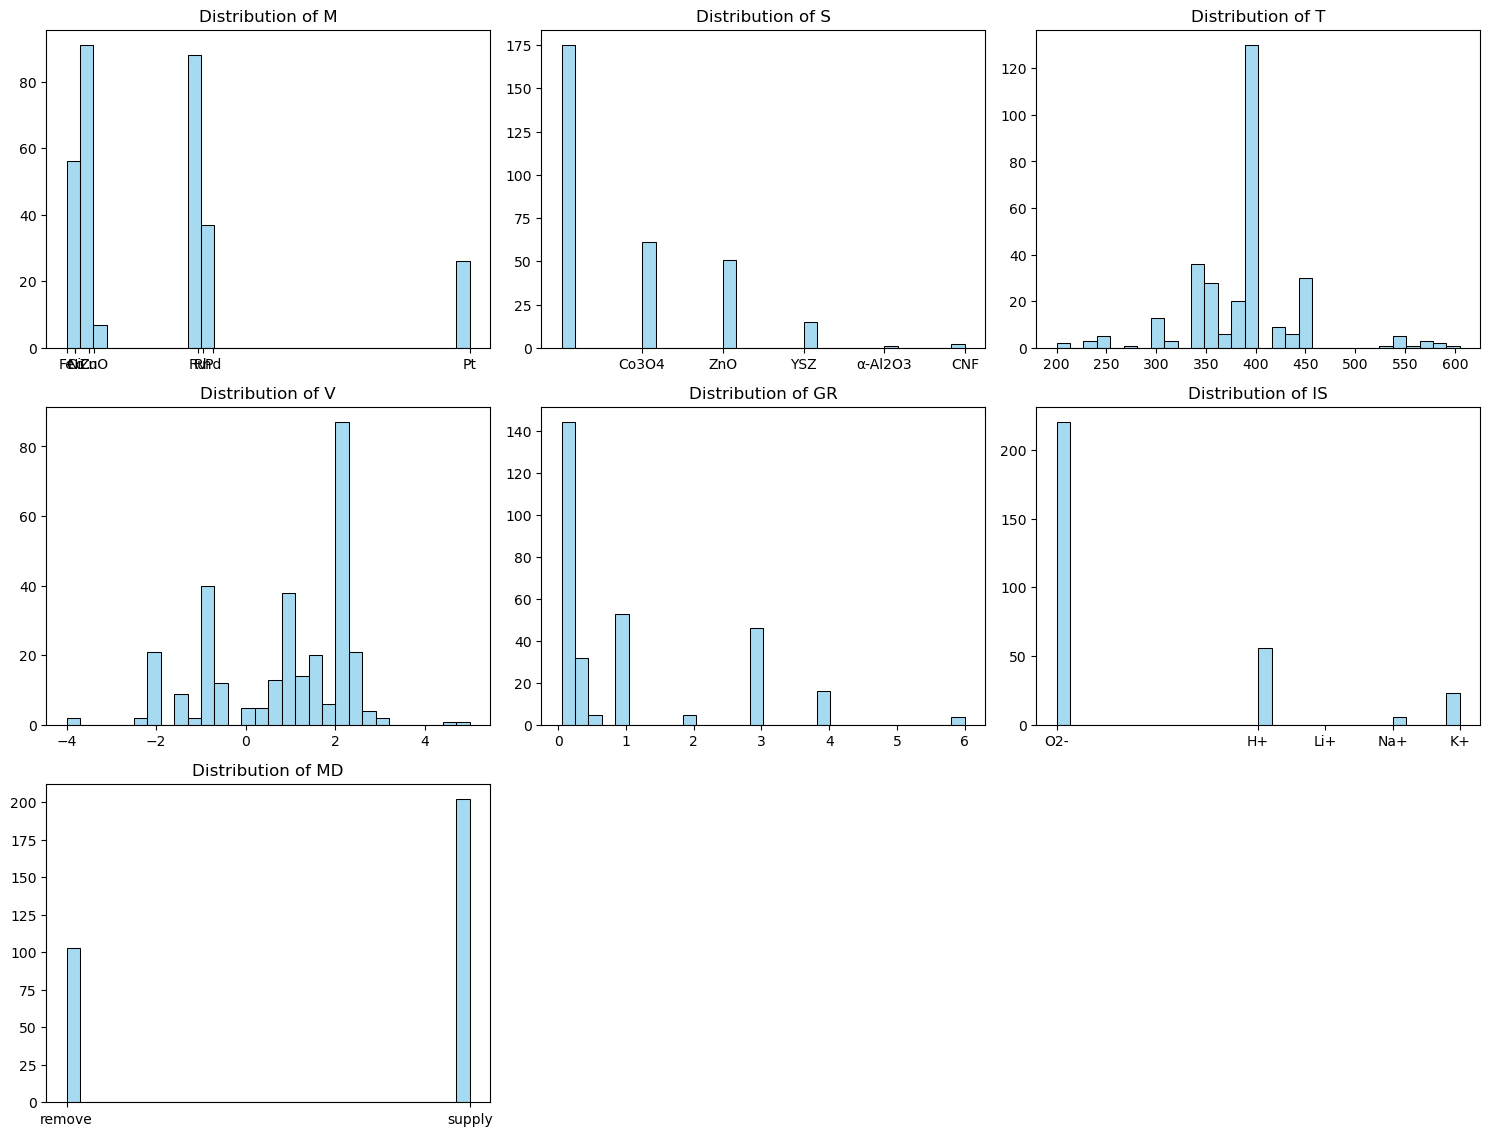

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read data
data = pd.read_excel('EPOC dataset.xlsx')

# Define columns
columns = ['metal', 'support', 'wt.%', 'ionic species', 'particle size(nm)', 'metal loading (mg)', 'CO2:H2 ratio', 'temp(℃)', 'rCO(mol/s)', 'voltage(V)', 'ρCO', 'ΛCO']
data = data[columns]

# Mapping dictionaries
metal_map = {'Fe': 55.8, 'Co': 58.9, 'Ni': 58.7, 'Cu': 63.5, 'ZnO': 65.4, 'Ru': 101.1, 'Rh': 102.9, 'Pd': 106.4, 'Pt': 195.1}
support_map = {'Co3O4': 1, 'ZnO': 2, 'YSZ': 3, 'α-Al2O3': 4, 'CNF': 5, np.nan: 0}
ionic_species_map = {'O2-': -2, 'H+': 1, 'Li+': 2, 'Na+': 3, 'K+': 4}

# Replace strings with mapped values
data['metal'] = data['metal'].replace(metal_map).astype(float)
data['support'] = data['support'].replace(support_map).astype(int)
data['wt.%'] = data['wt.%'].fillna(100).astype(float)
data['ionic species'] = data['ionic species'].replace(ionic_species_map).astype(int)
data['gas ratio'] = data['CO2:H2 ratio'].apply(lambda x: int(x.split(':')[0]) / int(x.split(':')[1]))
data = data.drop('CO2:H2 ratio', axis=1)

# Rename columns
data.columns = ['M', 'S', 'WT.%', 'IS', 'PS', 'L', 'T', 'R', 'V', 'ρ', 'Λ', 'GR']

# Determine ionic migration direction
def ionic_dir(row):
    return 1 if row['IS'] * row['V'] < 0 else 0

data['MD'] = data.apply(ionic_dir, axis=1)

# Classify EPOC behavior
def electro_class(row):
    if row['V'] > 0 and row['ρ'] >= 1:
        return 0
    elif row['V'] < 0 and row['ρ'] >= 1:
        return 1
    elif row['V'] > 0 and row['ρ'] <= 1:
        return 1
    elif row['V'] < 0 and row['ρ'] <= 1:
        return 0
    else:
        return 'undefined'

data['BH'] = data.apply(electro_class, axis=1)

# Features for plotting
features = ['M', 'S', 'T', 'V', 'GR', 'IS', 'MD']

# Reverse mapping for plot labels
reverse_metal_map = {v: k for k, v in metal_map.items()}
reverse_support_map = {v: k for k, v in support_map.items() if not pd.isna(k)}
reverse_ionic_species_map = {v: k for k, v in ionic_species_map.items()}
md_map = {0: 'remove', 1: 'supply'}

# Plot histograms
plt.figure(figsize=(15, 15))
for i, feature in enumerate(features):
    plt.subplot(4, 3, i+1)
    sns.histplot(data[feature], bins=30, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.ylabel('')

    # Set x-tick labels for specific features
    if feature == 'M':
        plt.xticks(ticks=list(reverse_metal_map.keys()), labels=list(reverse_metal_map.values()))
    elif feature == 'S':
        plt.xticks(ticks=list(reverse_support_map.keys()), labels=list(reverse_support_map.values()))
    elif feature == 'IS':
        plt.xticks(ticks=list(reverse_ionic_species_map.keys()), labels=list(reverse_ionic_species_map.values()))
    elif feature == 'MD':
        plt.xticks(ticks=list(md_map.keys()), labels=list(md_map.values()))

plt.tight_layout()
plt.savefig('feature_histograms.jpg', format='jpeg', dpi=600)
plt.show()

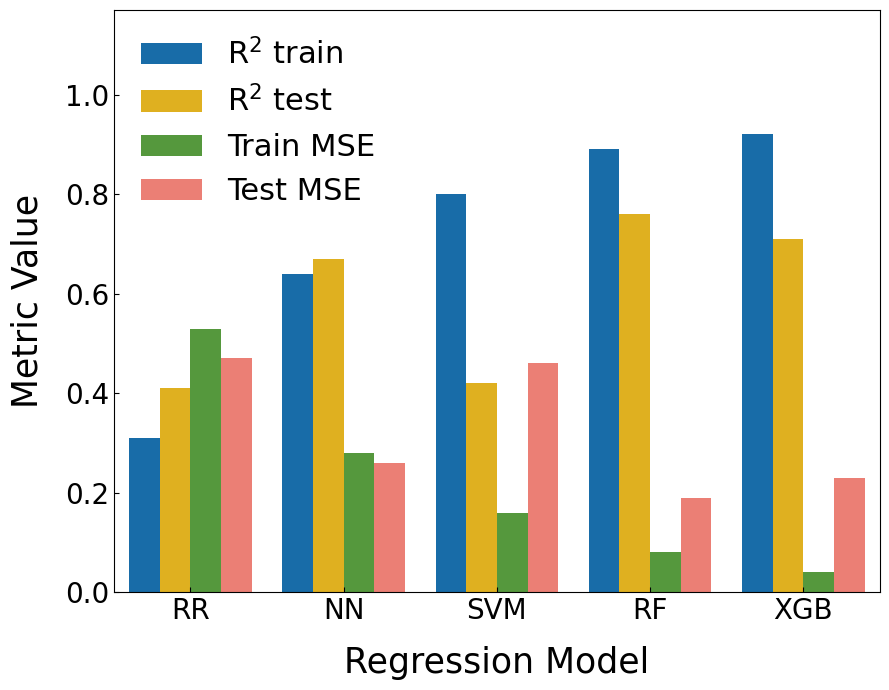

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
metric_file_path = 'ML models metrics.xlsx'
metric_data = pd.read_excel(metric_file_path)

# Select relevant columns
columns = ['RModel', 'R2 train', 'R2 test', 'Train MSE', 'Test MSE']
metric_data = metric_data[columns]

# Reshape the data for plotting
metric_data_melted = pd.melt(metric_data, id_vars=['RModel'], var_name='Metric', value_name='Value')

# Define custom colors
colors = {
    'R2 train': '#0070C0',
    'R2 test': '#FFC000',
    'Train MSE': '#4EA72E',
    'Test MSE': '#FF6F61'
}

# Create the bar plots for regression metrics
fig, ax1 = plt.subplots(figsize=(9, 7))
sns.barplot(x='RModel', y='Value', hue='Metric', data=metric_data_melted, palette=colors, ax=ax1)

# Set axis labels and limits
ax1.set_xlabel('Regression Model', size=25, labelpad=15)
ax1.set_ylabel('Metric Value', size=25, labelpad=15)
ax1.set_ylim(0, 1.17)
ax1.tick_params(axis='x', labelsize=20, direction='in')
ax1.tick_params(axis='y', labelsize=20, direction='in')

# Modify labels to include superscripts for R^2
handles, labels = ax1.get_legend_handles_labels()
new_labels = [label.replace('R2', 'R$^2$') for label in labels]
ax1.legend(handles=handles, labels=new_labels, fontsize=22, loc=2, frameon=False)

plt.tight_layout()
plt.savefig('Metric_regression.jpg', format='jpeg', dpi=600)
plt.show()

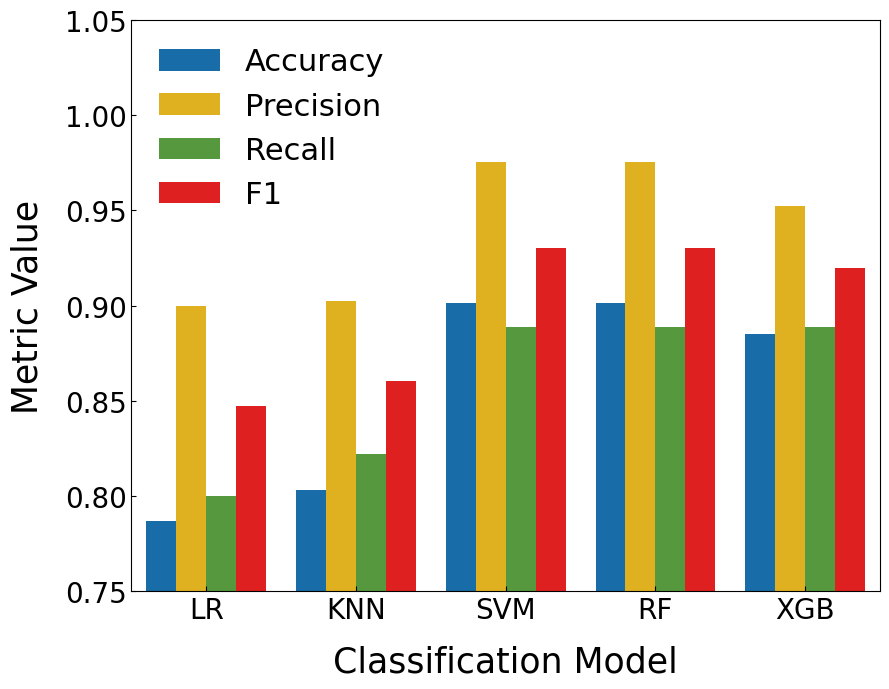

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
metric_file_path = 'ML models metrics.xlsx'
metric_data = pd.read_excel(metric_file_path)

# Select relevant columns
columns = ['CModel', 'Accuracy', 'Precision', 'Recall','F1']
metric_data = metric_data[columns]

# Reshape the data for plotting
metric_data_melted = pd.melt(metric_data, id_vars=['CModel'], var_name='Metric', value_name='Value')

# Define custom colors
colors = {
    'Accuracy': '#0070C0',
    'Precision': '#FFC000',
    'Recall': '#4EA72E',
    'F1': '#FF0000'
}

# Create the bar plots for regression metrics
fig, ax1 = plt.subplots(figsize=(9, 7))
sns.barplot(x='CModel', y='Value', hue='Metric', data=metric_data_melted, palette=colors, ax=ax1)

# Set axis labels and limits
ax1.set_xlabel('Classification Model', size=25, labelpad=15)
ax1.set_ylabel('Metric Value', size=25, labelpad=15)
ax1.set_ylim(0.75, 1.05)
ax1.tick_params(axis='x', labelsize=20, direction='in')
ax1.tick_params(axis='y', labelsize=20, direction='in')
ax1.legend(fontsize=22, loc=2, frameon=False)

plt.tight_layout()
plt.savefig('Metric_classification.jpg', format='jpeg', dpi=600)
plt.show()